In [1]:
import pandas as pd
import tensorflow as tf
from generic.deep_learning_tools.performance_metrics import EvaluationMetrics
from generic.deep_learning_tools.figures import Plotter
import numpy as np
import keras as K
import pylab as plt
%matplotlib inline
from sklearn.utils import class_weight
import numpy as np
import seaborn as sns


def plot_history(history, filename):
    loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
    f1_list = [s for s in history.history.keys() if 'f1' in s and 'val' not in s]
    val_f1_list = [s for s in history.history.keys() if 'f1' in s and 'val' in s]
    
    if len(loss_list) == 0:
        print('Loss is missing in history')
        return 

    ## As loss always exists
    epochs = range(1,len(history.history[loss_list[0]]) + 1)
    
    ## Loss
    fig = plt.figure(figsize=(15,5))
    plt.subplot(121)
    for l in loss_list:
        plt.plot(epochs, history.history[l], 'b', label='Training loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    for l in val_loss_list:
        plt.plot(epochs, history.history[l], 'g', label='Validation loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    ## F1
    plt.subplot(122)
    for l in f1_list:
        plt.plot(epochs, history.history[l], 'b', label='Training F1 (' + str(format(history.history[l][-1],'.5f'))+')')
    for l in val_f1_list:    
        plt.plot(epochs, history.history[l], 'g', label='Validation F1 (' + str(format(history.history[l][-1],'.5f'))+')')

    plt.title('F1')
    plt.xlabel('Epochs')
    plt.ylabel('F1')
    plt.legend()

INV_CLASS = {
    0: 'Black-grass',
    1: 'Charlock',
    2: 'Cleavers',
    3: 'Common Chickweed',
    4: 'Common wheat',
    5: 'Fat Hen',
    6: 'Loose Silky-bent',
    7: 'Maize',
    8: 'Scentless Mayweed',
    9: 'Shepherds Purse',
    10: 'Small-flowered Cranesbill',
    11: 'Sugar beet'
}

Using TensorFlow backend.


In [2]:
nb_classes = 12
img_width, img_height = 128, 128
train_data_dir = "../../data/train/"
validation_data_dir = "../../data/validation/"

batch_size = 32

# ResNet50 pretrained model
model = K.applications.ResNet50(weights = "imagenet", include_top=False, input_shape = (img_width,img_height, 3))
#Display Model's architecture
# model.summary()

# Dropout ratio
dropout_ratio = 0.5

# Freeze the layers which you don't want to train. 
unfrozen_layers=2
print('# unfrozen layers: {}'.format(unfrozen_layers))
if unfrozen_layers > 0:
    for layer in model.layers[-unfrozen_layers:]:
        layer.trainable = False
else:
    for layer in model.layers:
        layer.trainable = False
    
#Adding custom Layers 
x = model.output
x = K.layers.Flatten()(x)
x = K.layers.Dense(1024, activation="relu")(x)
x = K.layers.Dropout(dropout_ratio)(x)
x = K.layers.Dense(1024, activation="relu")(x)
predictions = K.layers.Dense(nb_classes, activation="softmax")(x)

# creating the final model 
model_final = K.models.Model(input = model.input, output = predictions)

# compile the model 
loss_rate = 0.0001
model_final.compile(loss = "categorical_crossentropy", optimizer = K.optimizers.Adam(lr=loss_rate), 
                    metrics=[EvaluationMetrics().f1])

# Use Data Augmentation
data_augmentation = True

print('Data augmentation in use? {}.'.format(data_augmentation))
if not data_augmentation:
    train_datagen = K.preprocessing.image.ImageDataGenerator(rescale = 1./255)
else:
    # Initiate the train and validation generators with data Augumentation 
    train_datagen = K.preprocessing.image.ImageDataGenerator(rescale = 1./255, 
                                                             horizontal_flip = True, 
                                                             vertical_flip = True,
                                                             fill_mode = 'nearest', 
                                                             zoom_range = 0.3,
                                                             width_shift_range = 0.3, 
                                                             height_shift_range = 0.3, 
                                                             rotation_range=360)

validation_datagen = K.preprocessing.image.ImageDataGenerator(rescale = 1./255)

train_generator = train_datagen.flow_from_directory(train_data_dir,target_size = (img_height, img_width),batch_size = batch_size, class_mode = "categorical")
validation_generator = validation_datagen.flow_from_directory(validation_data_dir,target_size = (img_height, img_width),class_mode = "categorical")

nb_train_samples = len(train_generator.filenames)
nb_validation_samples = len(validation_generator.filenames)

/home/virginie/anaconda3/envs/py35/lib/python3.5/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


# unfrozen layers: 2
Data augmentation in use? True.
Found 3800 images belonging to 12 classes.


/home/virginie/anaconda3/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:35: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


Found 950 images belonging to 12 classes.


# Dealing with unbalanced dataset
Once we have the basic benchmarks ready, it is time to improve over it. We can start with augmenting more data to increase the number of the 
images in the dataset. But first the dataset is not balanced, so we use a weighted loss function and a f1 score.

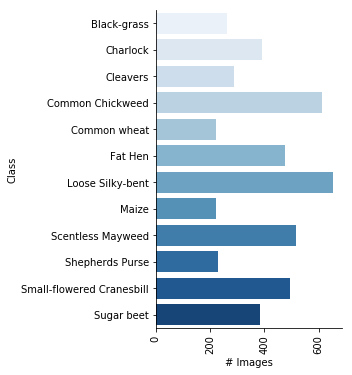

In [6]:
data_training = pd.DataFrame(train_generator.classes, columns=['Class'])
data_training['Data']='training'

data_validation = pd.DataFrame(validation_generator.classes, columns=['Class'])
data_validation['Data']='validation'

data = pd.concat([data_training, data_validation])
data.Class = data.Class.apply(lambda x: INV_CLASS[x])

# Plot Distribution Data By Crop
sns.catplot(y="Class", kind="count", data=data, palette="Blues");
_ = plt.xlabel('# Images')
_ = plt.xticks(rotation=90)

class_weights = class_weight.compute_class_weight(
           'balanced',
            np.unique(train_generator.classes), 
            train_generator.classes)

# Training model and save best ever model

Tensorboard records available under: resnet50_last_2_unfrozen_lr00001_with_data_augmentation
Epoch 1/100
118/118 [==============================] - 64s 546ms/step - loss: 2.0231 - f1: nan - val_loss: 1.0821 - val_f1: 0.6524
Epoch 2/100
118/118 [==============================] - 56s 473ms/step - loss: 0.9062 - f1: 0.6889 - val_loss: 1.1994 - val_f1: 0.7156
Epoch 3/100
118/118 [==============================] - 56s 471ms/step - loss: 0.6140 - f1: 0.7939 - val_loss: 0.4885 - val_f1: 0.8545
Epoch 4/100
118/118 [==============================] - 56s 471ms/step - loss: 0.5029 - f1: 0.8270 - val_loss: 0.4083 - val_f1: 0.8951
Epoch 5/100
118/118 [==============================] - 56s 472ms/step - loss: 0.4859 - f1: 0.8404 - val_loss: 0.4317 - val_f1: 0.8683
Epoch 6/100
118/118 [==============================] - 56s 474ms/step - loss: 0.3737 - f1: 0.8725 - val_loss: 0.3595 - val_f1: 0.8601
Epoch 7/100
118/118 [==============================] - 56s 472ms/step - loss: 0.3567 - f1: 0.8786 - val_lo

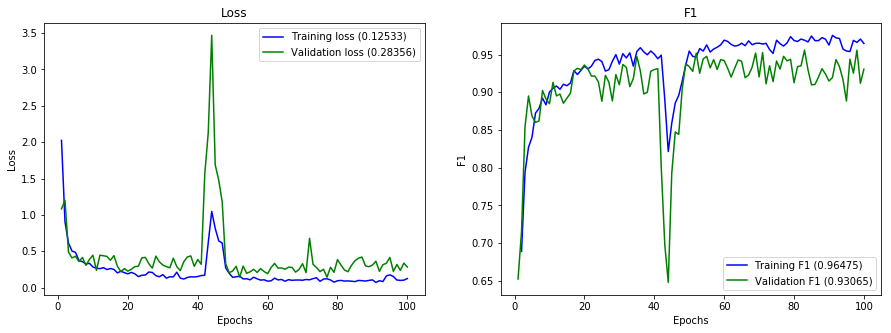

In [7]:
# Save the model according to the conditions  
checkpoint = K.callbacks.ModelCheckpoint("{}.h5".format(model.name), monitor='val_f1', verbose=1, save_best_only=True, save_weights_only=False)
early = K.callbacks.EarlyStopping(monitor='val_f1', verbose=1, mode='min', baseline=0.9,patience=10, min_delta=0.1)

epochs=100
filename = '{}_last_{}_unfrozen_lr{}_{}_data_augmentation'.format(model.name, unfrozen_layers, str(loss_rate).replace('.', ''), 'with' if 
                                     data_augmentation else 'without')
print('Tensorboard records available under: {}'.format(filename))

tensorboard = K.callbacks.TensorBoard(log_dir='./logs/{}'.format(filename),
                                     histogram_freq=0, write_graph=True, write_images=True)

history = model_final.fit_generator(train_generator,train_generator.n // batch_size, epochs=epochs, workers=4,
                                    class_weight=class_weights, validation_data=validation_generator, 
                                    callbacks=[tensorboard],validation_steps=validation_generator.n // batch_size)

plot_history(history, '{}.png'.format(filename))

# Plot confusion matrix validation samples

Found 950 images belonging to 12 classes.


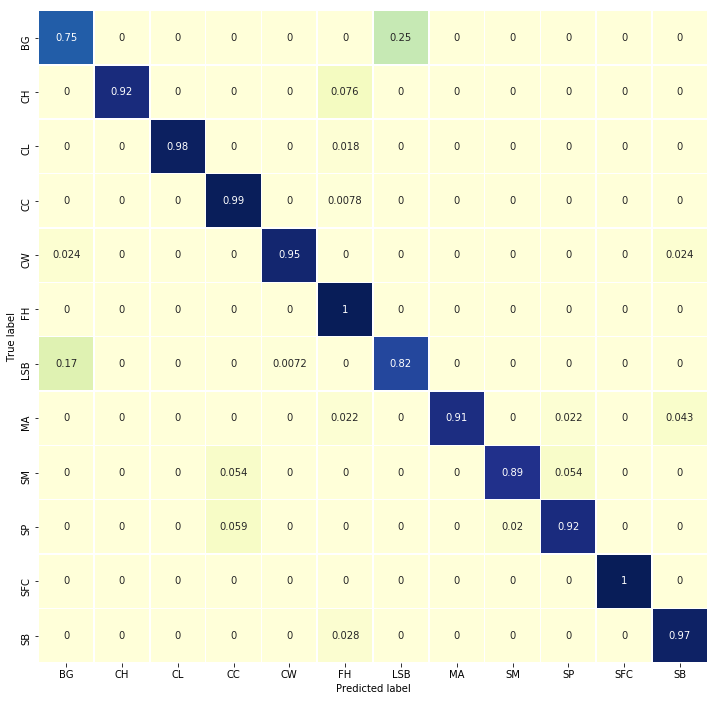

In [8]:
validation_datagen = K.preprocessing.image.ImageDataGenerator(rescale = 1./255)
validation_generator = validation_datagen.flow_from_directory(validation_data_dir,
                                                  target_size = (img_height, img_width),
                                                  class_mode = "categorical", 
                                                  shuffle=False,
                                                  batch_size=1)
steps = len(validation_generator.filenames)
Y_pred = model_final.predict_generator(validation_generator, steps=steps)
y_pred = np.argmax(Y_pred, axis=1)
y_true = validation_generator.classes

normalised_confusion_matrix = EvaluationMetrics().normalised_confusion_matrix(y_true, y_pred)

ticklabels = ['BG', 'CH', 'CL', 'CC', 'CW', 'FH', 'LSB', 'MA', 'SM', 'SP', 'SFC', 'SB']

_ = Plotter().plot_confusion_matrix(confusion_matrix=normalised_confusion_matrix,
                               ticklabels=ticklabels)

In [9]:
model_final.save('resnet_transfer_learning_01042019.h5')

# Prediction on test set

In [10]:
test_data_dir = '../../data/test/'
test_datagen = K.preprocessing.image.ImageDataGenerator(rescale = 1./255)
test_generator = test_datagen.flow_from_directory(test_data_dir,
                                                  target_size = (img_height, img_width),
                                                  class_mode = None, 
                                                  shuffle=False,
                                                  batch_size=1)
steps = len(test_generator.filenames)
Y_pred = model_final.predict_generator(test_generator, steps=steps)
y_pred = np.argmax(Y_pred, axis=1)

import pandas as pd
submission = pd.DataFrame(test_generator.filenames, columns=['file'])
submission['file'] = submission.file.apply(lambda x: x.split('/')[-1])
submission['classes'] = y_pred
submission['species'] = submission.classes.apply(lambda x: INV_CLASS[x])
del submission['classes']
submission.head()

submission.to_csv('/home/virginie/submission.csv', index=False)

Found 794 images belonging to 1 classes.
